# LeNet
MNIST数据集<br>
LeNet结构
![LeNet](./LeNet.png)
5 * 5卷积层 -> 2 * 2池化层 -> 5 * 5卷积层 -> 2 * 2池化层 -> 全连接层

In [1]:
import torch 
from torch import nn
from d2l import torch as d2l

class Reshape(torch.nn.Module):
    def forward(self, x): # 定义传入的是什么东西
        return x.view(-1, 1, 28, 28) # -1 自动推断维度


net = nn.Sequential( # 输入28*28因为图片删掉了两行，因此在下面的函数中通过padding变成了32*32
    Reshape(), # 相当于自己定义了一个网络
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(), # 通道到通道
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)


验证Reshape的作用

In [3]:
temp= Reshape()
X = torch.rand(2, 28, 28)
X = temp(X)
print(X.shape) # torch.Size([2, 1, 28, 28])

torch.Size([2, 1, 28, 28])


检查模型

In [4]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape, '\t', X.type())


Reshape output shape: 	 torch.Size([1, 1, 28, 28]) 	 torch.FloatTensor
Conv2d output shape: 	 torch.Size([1, 6, 28, 28]) 	 torch.FloatTensor
ReLU output shape: 	 torch.Size([1, 6, 28, 28]) 	 torch.FloatTensor
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14]) 	 torch.FloatTensor
Conv2d output shape: 	 torch.Size([1, 16, 10, 10]) 	 torch.FloatTensor
ReLU output shape: 	 torch.Size([1, 16, 10, 10]) 	 torch.FloatTensor
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5]) 	 torch.FloatTensor
Flatten output shape: 	 torch.Size([1, 400]) 	 torch.FloatTensor
Linear output shape: 	 torch.Size([1, 120]) 	 torch.FloatTensor
Sigmoid output shape: 	 torch.Size([1, 120]) 	 torch.FloatTensor
Linear output shape: 	 torch.Size([1, 84]) 	 torch.FloatTensor
Sigmoid output shape: 	 torch.Size([1, 84]) 	 torch.FloatTensor
Linear output shape: 	 torch.Size([1, 10]) 	 torch.FloatTensor


LeNet在Fashion-MNIST数据集上的表现

In [28]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

评估函数

In [29]:
def evaluate_accuracy_gpu(net, data_iter, device=None):  
    """使用GPU计算模型在数据集上的精度。"""
    if isinstance(net, torch.nn.Module):
        net.eval() # 设置模型为评估模式
        if not device:
            device = next(iter(net.parameters())).device # 获取模型参数所在的设备
    metric = d2l.Accumulator(2) # 累加器存储 [正确预测数, 总样本数]
    for X, y in data_iter:
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device) # 模型迁移到指定设备基本等效于.to('cuda')
        metric.add(d2l.accuracy(net(X), y), y.numel()) # y.numel()返回张量中元素总数
    return metric[0] / metric[1]

为了使用GPU，需要修改一下训练函数

In [ ]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight) # 初始化权重
    net.apply(init_weights) # 对其中的每个parameter都run内部的函数
    print('training on', device)
    net.to(device) # 参数搬到GPU上
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc']) # 动画效果
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter): # 每次迭代拿出一个batch
            timer.start()
            optimizer.zero_grad() # 梯度设为零 pytorch中默认是累加的,所以每个batch要清零
            X, y = X.to(device), y.to(device) # 输入输出挪到GPU上
            y_hat = net(X) # 前向
            l = loss(y_hat, y) # 计算损失
            l.backward() # 计算梯度
            optimizer.step() # 迭代
            
            # 下面是动画信息
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.302, train acc 0.886, test acc 0.867
77516.3 examples/sec on cuda:0


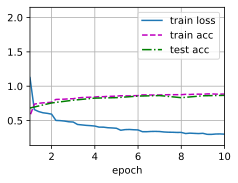

In [33]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

现在的深度学习不需要很多的数据集<br>